In [4]:
import tensorflow as tf
import os
import cv2
import time
print(tf.__version__)

2.16.1


In [5]:
from tensorflow.keras.models import load_model, Model
import json
import h5py

path_model = './my_model_NetV2.h5'

# Load the model
with h5py.File(path_model, 'r+') as f:
  if 'model_config' in f.attrs:
    config = f.attrs['model_config']
    model_config = json.loads(config)
    for layer in model_config['config']['layers']:
      if layer['class_name'] == 'DepthwiseConv2D':
        # Remove the 'groups' parameter if it exists
        if 'groups' in layer['config']:
          del layer['config']['groups']
    # Update the model configuration in the file
    f.attrs['model_config'] = json.dumps(model_config).encode('utf-8')

model = load_model(path_model)

# Đường dẫn đến file JSON chứa thông tin ánh xạ nhãn
json_file_path = './labels.json'

# Đọc nội dung từ file JSON
with open(json_file_path, 'r') as json_file:
    labels_dict = json.load(json_file)

print(len(labels_dict))

37


In [6]:
from glob import glob

training_dir = './Dataspl/Train/'
validation_dir = './Dataspl/Validation/'
test_dir = './Dataspl/Test/'

image_files = glob(training_dir + '/*/*.jp*g')
valid_image_files = glob(validation_dir + '/*/*.jp*g')

# getting the number of classes i.e. type of fruits
folders = glob(training_dir + '/*')
num_classes = len(folders)
print ('Total Classes = ' + str(num_classes))

Total Classes = 38


In [7]:
from keras.layers import Dense
#from keras.preprocessing import image

IMAGE_SIZE = [224, 224]  # we will keep the image size as (64,64). You can increase the size for better results.

# Remove the last layer from the model
model_layers = model.layers[:-1]

# Add a new output layer
output = Dense(num_classes, activation='softmax', name='new_output')(model_layers[-1].output)
model = Model(inputs=model.input, outputs=output)

print("[INFO] compiling model ...")
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Freeze the layers in the original model
for layer in model.layers[:-1]:
    layer.trainable = False

for layer in model.layers:
  print('Layer: {} ; Trainable: {}'.format(layer, layer.name))


[INFO] compiling model ...
Layer: <InputLayer name=input_1, built=True> ; Trainable: input_1
Layer: <Conv2D name=Conv1, built=True> ; Trainable: Conv1
Layer: <BatchNormalization name=bn_Conv1, built=True> ; Trainable: bn_Conv1
Layer: <ReLU name=Conv1_relu, built=True> ; Trainable: Conv1_relu
Layer: <DepthwiseConv2D name=expanded_conv_depthwise, built=True> ; Trainable: expanded_conv_depthwise
Layer: <BatchNormalization name=expanded_conv_depthwise_BN, built=True> ; Trainable: expanded_conv_depthwise_BN
Layer: <ReLU name=expanded_conv_depthwise_relu, built=True> ; Trainable: expanded_conv_depthwise_relu
Layer: <Conv2D name=expanded_conv_project, built=True> ; Trainable: expanded_conv_project
Layer: <BatchNormalization name=expanded_conv_project_BN, built=True> ; Trainable: expanded_conv_project_BN
Layer: <Conv2D name=block_1_expand, built=True> ; Trainable: block_1_expand
Layer: <BatchNormalization name=block_1_expand_BN, built=True> ; Trainable: block_1_expand_BN
Layer: <ReLU name=bloc

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_1             │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_1[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,342,438 (8.94 MB)

 Trainable params: 2,470 (9.65 KB)

 Non-trainable params: 2,339,968 (8.93 MB)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input

training_datagen = ImageDataGenerator(
                                    rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

training_generator = training_datagen.flow_from_directory(training_dir, target_size = IMAGE_SIZE, batch_size = 200, class_mode = 'categorical')
validation_generator = validation_datagen.flow_from_directory(validation_dir, target_size = IMAGE_SIZE, batch_size = 200, class_mode = 'categorical')
test_generator = test_datagen.flow_from_directory(test_dir, target_size = IMAGE_SIZE, batch_size = 200, class_mode = 'categorical')

Found 12168 images belonging to 38 classes.
Found 2716 images belonging to 38 classes.
Found 2604 images belonging to 38 classes.


In [10]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)
start_time = time.time()

history = model.fit(training_generator,
                   epochs = 30,  # change this for better results
                   validation_data = validation_generator,
                    callbacks = [early_stopping]
                   )

end_time = time.time()
time_train_seconds = end_time - start_time
time_train_minutes = time_train_seconds / 60

model.save('./my_model_update.h5')

Epoch 1/30


c:\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 9/61 ━━━━━━━━━━━━━━━━━━━━ 4:52 6s/step - accuracy: 0.0314 - loss: 5.3600

c:\Python312\Lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


61/61 ━━━━━━━━━━━━━━━━━━━━ 410s 6s/step - accuracy: 0.0453 - loss: 4.9095 - val_accuracy: 0.2581 - val_loss: 2.7592
Epoch 2/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 304s 5s/step - accuracy: 0.1556 - loss: 3.3439 - val_accuracy: 0.5306 - val_loss: 1.8394
Epoch 3/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 290s 5s/step - accuracy: 0.3131 - loss: 2.4448 - val_accuracy: 0.6443 - val_loss: 1.4123
Epoch 4/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 300s 5s/step - accuracy: 0.4083 - loss: 1.9953 - val_accuracy: 0.6907 - val_loss: 1.1994
Epoch 5/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 312s 5s/step - accuracy: 0.4891 - loss: 1.7080 - val_accuracy: 0.7216 - val_loss: 1.0776
Epoch 6/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.5301 - loss: 1.5710 - val_accuracy: 0.7386 - val_loss: 1.0017
Epoch 7/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 311s 5s/step - accuracy: 0.5692 - loss: 1.4495 - val_accuracy: 0.7437 - val_loss: 0.9535
Epoch 8/30
61/61 ━━━━━━━━━━━━━━━━━━━━ 314s 5s/step - accuracy: 0.5887 - loss: 1.3687 - val_accuracy: 0.7511 - val_loss: 0.

In [11]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_matrix(Y_test, pred, lb):
  # Tính ma trận nhầm lẫn
  cm = confusion_matrix(Y_test.argmax(axis=1), pred)
  # Hiển thị ma trận nhầm lẫn bằng heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title('Confusion Matrix')
  plt.show()

In [12]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [13]:
def plot_accuracy(history):
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

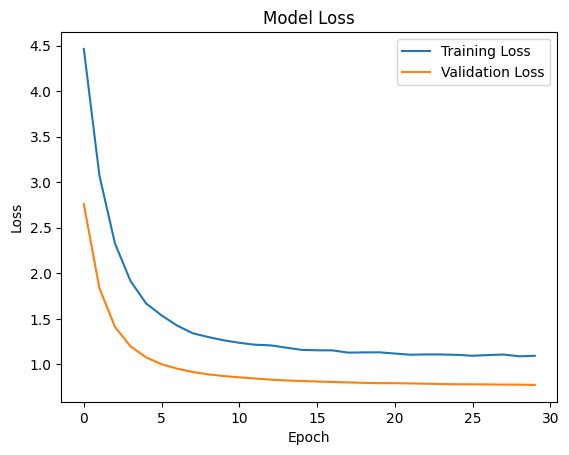

In [14]:
plot_loss(history)

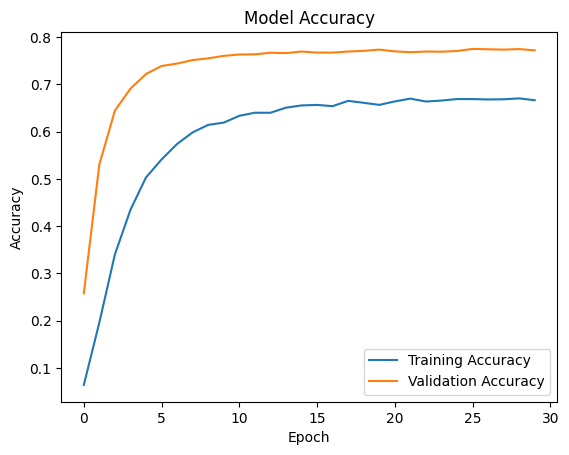

In [15]:
plot_accuracy(history)

In [16]:
print(time_train_minutes)

156.16133809487025
